In [14]:
import tensorflow as tf
from tensorflow_addons.layers import InstanceNormalization
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv1D, Activation, Flatten, Input, Reshape, LeakyReLU
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
import pathlib
import shutil
import tempfile
import math
import numpy as np
import json
from scipy.io import loadmat
import matplotlib.pyplot as plt
import os
import numpy as np
from os.path import join, exists, basename, split
from spectral import *

from os import listdir
from os.path import isfile, join
from os import walk
import glob
from sklearn.model_selection import train_test_split
from spectral import *

print(tf.__version__)

2.3.0


In [15]:
### Limit GPU Memory growth ###
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Define Data loading Function ###

In [16]:
def load_data(name):
    images = []
    
    print(name+"----------")
    datas = []
    u = 0
    
    for filename in glob.glob(name+"/*.npy"):

        datas.append(filename)
        u = u + 1

    print("Number of Samples :    "+str(u))
        
    return datas

In [17]:
all_images = load_data(r"E:\intermediate_notebooks\hermi_combined");# List containing names (string) of the datasets in pavC

E:\intermediate_notebooks\hermi_combined----------
Number of Samples :    1512


### Define Training and Testing Data Split)

In [18]:
np.random.seed(25)
train_images, test_images = train_test_split(all_images, test_size=0.25, shuffle=True)

In [19]:
print(len(train_images))
print(len(test_images))

1134
378


# Define batch and validation data generators ###

In [20]:
def myBatchGenerator(batch_size, images):  
    batch_counter = 0
    save_batch = 0
    while True:    
        batch_image = []
        batch_label = []
        while batch_counter < batch_size + save_batch:
            rand_ind = np.random.randint(len(images));#Random index number to access list

            filename = images[batch_counter]
            theImage = np.load(filename)
            #The input image and the batch label should be the same in this case
            
            batch_image.append(theImage)
            batch_label.append(theImage)
            
            #print(theImage.shape)
            batch_counter = batch_counter + 1
            #print("batch_counter : "+str(batch_counter))
        #print("batch_size + save_batch : "+str(batch_size + save_batch))
        if(batch_counter == len(images)-1 or (batch_size + save_batch) > len(images)-1):
            batch_counter = 0
            save_batch = 0
            
        save_batch = batch_counter
        BI = np.array(batch_image)#.as...
        BL = np.array(batch_label)#.astype(np.float32);#Batch labe
        yield BI, BL

In [21]:
def myValidGenerator(batch_size, images): #Load images in a non-random way
    
    batch_counter = 0
    while True:
        batch_image = []
        batch_label = []
        while batch_counter < batch_size:
            rand_ind = np.random.randint(len(images));#Random index number to access list

            filename = images[rand_ind]
            #filename = images[batch_counter]
            theImage = np.load(filename)

            batch_image.append (theImage)
            #print(theImage.shape)

            batch_label.append(theImage)

            batch_counter = batch_counter + 1
        batch_counter = 0
        
        BI = np.array(batch_image)#.astype(np.float32);#Batch image
#         print("Validation")
#         for i in range(len(batch_label)):
#             print(batch_label[i].shape)
            
        BL = np.array(batch_label)#.astype(np.float32);#Batch labe
        yield BI, BL;# Yield gives a sequence of values?

#### Generate training and validation data from file ####

In [22]:
BATCH_SIZE = 21; # Common divisor for 207 and 621
train_batch = myBatchGenerator(BATCH_SIZE, train_images)
test_batch = myValidGenerator(BATCH_SIZE, test_images)

## Define custom loss function

In [23]:
def loss_function_reconstruction_1D(y_reconstructed, y_target, func='SID'):
    """ Reconstruction loss function op, comparing 1D tensors for network reconstruction and target.

    Args:
        y_reconstructed (tensor): Output of network (reconstructed 1D vector). Shape [numSamples x inputSize].
        y_target (tensor): What the network is trying to reconstruct (1D vector). Shape [numSamples x inputSize].
        func (string): The name of the loss function to be used. 'SSE'-sum of square errors,'CSA'-cosine spectral angle, \
            'SA'-spectral angle, 'SID'-spectral information divergence.

    Returns:
        (tensor): Reconstruction loss.
    """
    if func == 'SSE':
        # sum of squared errors loss
        loss = tf.reduce_sum( tf.square(y_target - y_reconstructed) )

    elif func == 'CSA':
        # cosine of spectral angle loss
        normalize_r = tf.math.l2_normalize(tf.transpose(y_reconstructed), axis=0)
        normalize_t = tf.math.l2_normalize(tf.transpose(y_target), axis=0)
        
        loss = tf.reduce_sum( 1 - tf.reduce_sum(tf.multiply(normalize_r, normalize_t),axis=0 ) )

    elif func == 'SA':
        # spectral angle loss
        normalize_r = tf.math.l2_normalize(tf.transpose(y_reconstructed),axis=0)
        normalize_t = tf.math.l2_normalize(tf.transpose(y_target),axis=0)
        loss = tf.reduce_sum( tf.math.acos(tf.reduce_sum(tf.multiply(normalize_r, normalize_t),axis=0 ) ) )

    elif func == 'SID':
        # spectral information divergence loss
        loss = 0;
        #y_target = y_target.numpy();
        #y_reconstructed = y_reconstructed.numpy();#23, 64, 64, 102
        
        for i in range(23):
            
            y_tar_temp = y_target[i]#.numpy();#64x64x102
            y_rec_temp = y_reconstructed[i]#.numpy();#64x64x102
            y_tar_temp = tf.reshape(y_tar_temp, (-1, 102));#(64x64, 102)
            y_rec_temp = tf.reshape(y_rec_temp, (-1, 102));#(64x64, 102)
            print(tf.shape(y_tar_temp))
            print(tf.shape(y_rec_temp))
            t = tf.math.divide( tf.transpose(y_tar_temp) , tf.math.reduce_mean(tf.transpose(y_tar_temp)) )
            r = tf.math.divide( tf.transpose(y_rec_temp) , tf.math.reduce_mean(tf.transpose(y_rec_temp)) )
            loss += tf.math.reduce_mean(
                tf.reduce_sum( tf.math.multiply(t,tf.math.log(tf.math.divide(t,r))) )
                                  + tf.math.reduce_mean( tf.math.multiply(r,tf.math.log(tf.math.divide(r,t))) ) )
            print("one-----------------------------")
            print(y_tar_temp)
            
            print("two---------------------------------")
            print(y_rec_temp)
            
            print("three------------------------")
            print(t)
            
            print("Loss------------------------")
            print(loss)
            print(" Index : " + str(i))
            
        loss = loss/23
        
        return  loss
    
#     elif func == 'SID':
#         # spectral information divergence loss
        
#         #y_target = y_target.numpy();
#         #y_reconstructed = y_reconstructed.numpy();#23, 64, 64, 102
        
#         y_tar_temp = tf.reshape(y_target, (23, 64*64,102));#(64x64, 102)
#         y_rec_temp = tf.reshape(y_reconstructed, (23, 64*64, 102));#(64x64, 102)
#         t = tf.math.divide( tf.transpose(y_target) , tf.math.reduce_mean(tf.transpose(y_reconstructed),axis=0) )
#         r = tf.math.divide( tf.transpose(y_reconstructed) , tf.math.reduce_mean(tf.transpose(y_reconstructed),axis=0) )
#         loss = tf.math.reduce_mean( tf.reduce_sum( tf.math.multiply(t,tf.math.log(tf.math.divide(t,r))) , axis=0)
#                                   + tf.math.reduce_mean( tf.math.multiply(r,tf.math.log(tf.math.divide(r,t))) , axis=0) )
#         print(loss)
#         return  loss
                                    
    elif func == 'MAE':
        # sum of squared errors loss
        loss = tf.reduce_mean( tf.math.abs(y_target - y_reconstructed) )
        
    elif func == 'SMS':
        # Combined loss function of SID, SSE, SSE, MAE
        y_target_sq = y_target.numpy()
        y_recon_sq = y_reconstructed.numpy()
        if (len(y_target.shape) == 4):
            y_target_sq = np.squeeze(y_target)
            print("Target has been squeezed!")
            print(y_target_sq.shape)
        if (len(y_target.shape) == 4):
            y_recon_sq = np.squeeze(y_reconstructed)
            print("Recon has been squeezed!")
            print(y_recon_sq.shape)
        y_target_re = tf.reshape(y_target_sq, (-1, y_target_sq.shape[2]))
        y_recon_re = tf.reshape(y_recon_sq, (-1, y_recon_sq.shape[2]))
        t = tf.math.divide( tf.transpose(y_target_re) , tf.math.reduce_mean(tf.transpose(y_target_re),axis=0) )
        r = tf.math.divide( tf.transpose(y_recon_re) , tf.math.reduce_mean(tf.transpose(y_recon_re),axis=0) )
        loss_1 = tf.math.reduce_mean( tf.math.reduce_mean( tf.math.multiply(t,tf.math.log(tf.math.divide(t,r))) , axis=0)
                              + tf.math.reduce_mean( tf.math.multiply(r, tf.math.log(tf.math.divide(r,t))) , axis=0) )
        loss = tf.reduce_mean( tf.math.abs(y_target - y_reconstructed) ) + loss_1;

    else:
        raise ValueError('unknown loss function: %s. Use SSE, CSA, SA or SID.' % func)

    return loss

## Define the encoder section of the AE ###

In [24]:
input_shape = (64, 64, 242)
theInput = Input(input_shape)

convAE = Conv2D(filters = 242, kernel_size = (7, 7), padding='same', activation = LeakyReLU())(theInput)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE)
convAE = Conv2D(filters = 200, kernel_size = (5, 5), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE)
convAE = Conv2D(filters = 158, kernel_size = (5, 5), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE)
convAE = Conv2D(filters = 116, kernel_size = (3, 3), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE)
convAE = Conv2D(filters = 74, kernel_size = (3, 3), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE)
convAE = Conv2D(filters = 32, kernel_size = (3, 3), padding='same', activation = LeakyReLU())(convAE)
convAE = Dropout(0.5)(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE)

encoder_2d = Model(inputs = theInput, outputs = convAE);
encoder_2d.summary();

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 242)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 242)       2869878   
_________________________________________________________________
instance_normalization_11 (I (None, 64, 64, 242)       484       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 200)       1210200   
_________________________________________________________________
instance_normalization_12 (I (None, 64, 64, 200)       400       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 158)       790158    
_________________________________________________________________
instance_normalization_13 (I (None, 64, 64, 158)      

## Define Decoder ####

In [25]:
convAE = Conv2DTranspose(filters = 32, kernel_size = (3, 3), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE);
convAE = Conv2DTranspose(filters = 74, kernel_size = (3, 3), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE);
convAE = Conv2DTranspose(filters = 116, kernel_size = (3, 3), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE);
convAE = Conv2DTranspose(filters = 158, kernel_size = (5, 5), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE);
convAE = Conv2DTranspose(filters = 200, kernel_size = (5, 5), padding='same', activation = LeakyReLU())(convAE)
convAE = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(convAE);
convAE = Conv2DTranspose(filters = 242, kernel_size = (7, 7), padding='same', activation = "tanh")(convAE)
#drop = Dropout(0.5)(conv2d_6)
#instance_6 = InstanceNormalization(axis=3, center=True, scale=True, beta_initializer='random_uniform', gamma_initializer='random_uniform')(drop);
ae_combined = tf.keras.Model(inputs = theInput, outputs = convAE);
ae_combined.summary();

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 242)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 242)       2869878   
_________________________________________________________________
instance_normalization_11 (I (None, 64, 64, 242)       484       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 200)       1210200   
_________________________________________________________________
instance_normalization_12 (I (None, 64, 64, 200)       400       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 158)       790158    
_________________________________________________________________
instance_normalization_13 (I (None, 64, 64, 158)      

## Define training log paths ##

In [26]:
logdir = pathlib.Path(r"E:\dim_reduc_desktop1_cae\dim_reduc_hermi")/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
logdir

WindowsPath('E:/dim_reduc_desktop1_cae/dim_reduc_hermi/tensorboard_logs')

## Define training callbacks

In [28]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='mae', patience=20),
    tf.keras.callbacks.TensorBoard(logdir/name),
    tf.keras.callbacks.ModelCheckpoint(
        "hermi_dim_reduc_cae_v1.h5", monitor='val_loss', verbose=1, save_best_only=True,
         mode='min')
  ]

In [19]:
ae_combined.compile(optimizer = 'adam', loss = 'mae', metrics = "mae")

In [ ]:
history_v1 = ae_combined.fit(train_batch, 
                          steps_per_epoch=54, 
                          epochs=30, 
                          verbose=1,
                          validation_data=test_batch, 
                          validation_steps=1,
                          callbacks = get_callbacks("updated")
                          )

Epoch 1/30
 1/54 [..............................] - ETA: 0s - loss: 0.1092 - mae: 0.1092WARNING:tensorflow:From c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
54/54 [==============================] - ETA: 0s - loss: 0.0424 - mae: 0.0424
Epoch: 0, loss:0.0424,  mae:0.0424,  val_loss:0.0293,  val_mae:0.0293,  
.
Epoch 00001: val_loss improved from inf to 0.02934, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 43s 796ms/step - loss: 0.0424 - mae: 0.0424 - val_loss: 0.0293 - val_mae: 0.0293
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 0.0265 - mae: 0.0265.
Epoch 00002: val_loss improved from 0.02934 to 0.02230, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 336s 6s/step - 

In [27]:
cae_chkpt = load_model("hermi_dim_reduc_cae_v1.h5", custom_objects={"LeakyReLU":LeakyReLU()})

In [29]:
history_v2 = cae_chkpt.fit(train_batch, 
                          steps_per_epoch=54, 
                          epochs=30, 
                          verbose=1,
                          validation_data=test_batch, 
                          validation_steps=1,
                          callbacks = get_callbacks("updated")
                          )

Epoch 1/30
 1/54 [..............................] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.0079WARNING:tensorflow:From c:\users\cvr 2019 2020\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


 2/54 [>.............................] - ETA: 18s - loss: 0.0079 - mean_absolute_error: 0.0079WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1983s vs `on_train_batch_end` time: 0.4945s). Check your callbacks.


54/54 [==============================] - ETA: 0s - loss: 0.0081 - mean_absolute_error: 0.0081
Epoch: 0, loss:0.0081,  mean_absolute_error:0.0081,  val_loss:0.0074,  val_mean_absolute_error:0.0074,  



Epoch 00001: val_loss improved from inf to 0.00741, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 38s 705ms/step - loss: 0.0081 - mean_absolute_error: 0.0081 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 2/30
54/54 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0084.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00002: val_loss did not improve from 0.00741
54/54 [==============================] - 36s 660ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0087 - val_mean_absolute_error: 0.0087
Epoch 3/30
54/54 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.0084.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00003: val_loss did not improve from 0.00741
54/54 [==============================] - 35s 655ms/step - loss: 0.0084 - mean_absolute_error: 0.0084 - val_loss: 0.0079 - val_mean_absolute_error: 0.0079
Epoch 4/30
54/54 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.0077.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00004: val_loss improved from 0.00741 to 0.00681, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 36s 672ms/step - loss: 0.0077 - mean_absolute_error: 0.0077 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 5/30
54/54 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.0072.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00005: val_loss did not improve from 0.00681
54/54 [==============================] - 36s 671ms/step - loss: 0.0072 - mean_absolute_error: 0.0072 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 6/30
54/54 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0069.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00006: val_loss did not improve from 0.00681
54/54 [==============================] - 36s 661ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0069 - val_mean_absolute_error: 0.0069
Epoch 7/30
54/54 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0070.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00007: val_loss improved from 0.00681 to 0.00656, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 36s 661ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0066 - val_mean_absolute_error: 0.0066
Epoch 8/30
54/54 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0070.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00008: val_loss did not improve from 0.00656
54/54 [==============================] - 36s 661ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0074 - val_mean_absolute_error: 0.0074
Epoch 9/30
54/54 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.0065.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00009: val_loss improved from 0.00656 to 0.00617, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 37s 677ms/step - loss: 0.0065 - mean_absolute_error: 0.0065 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062
Epoch 10/30
54/54 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.0070.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00010: val_loss did not improve from 0.00617
54/54 [==============================] - 37s 683ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0068 - val_mean_absolute_error: 0.0068
Epoch 11/30
54/54 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0069.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00011: val_loss did not improve from 0.00617
54/54 [==============================] - 36s 674ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0072 - val_mean_absolute_error: 0.0072
Epoch 12/30
54/54 [==============================] - ETA: 0s - loss: 0.0069 - mean_absolute_error: 0.0069.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00012: val_loss did not improve from 0.00617
54/54 [==============================] - 37s 676ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0075 - val_mean_absolute_error: 0.0075
Epoch 13/30
54/54 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.0064.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00013: val_loss did not improve from 0.00617
54/54 [==============================] - 37s 687ms/step - loss: 0.0064 - mean_absolute_error: 0.0064 - val_loss: 0.0062 - val_mean_absolute_error: 0.0062
Epoch 14/30
54/54 [==============================] - ETA: 0s - loss: 0.0063 - mean_absolute_error: 0.0063.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00014: val_loss improved from 0.00617 to 0.00599, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 49s 903ms/step - loss: 0.0063 - mean_absolute_error: 0.0063 - val_loss: 0.0060 - val_mean_absolute_error: 0.0060
Epoch 15/30
54/54 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.0058.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00015: val_loss improved from 0.00599 to 0.00501, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 38s 699ms/step - loss: 0.0058 - mean_absolute_error: 0.0058 - val_loss: 0.0050 - val_mean_absolute_error: 0.0050
Epoch 16/30
54/54 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0057.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00016: val_loss did not improve from 0.00501
54/54 [==============================] - 36s 676ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 17/30
54/54 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.0061.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00017: val_loss did not improve from 0.00501
54/54 [==============================] - 36s 665ms/step - loss: 0.0061 - mean_absolute_error: 0.0061 - val_loss: 0.0059 - val_mean_absolute_error: 0.0059
Epoch 18/30
54/54 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0055.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00018: val_loss did not improve from 0.00501
54/54 [==============================] - 36s 671ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053
Epoch 19/30
54/54 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0053.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00019: val_loss did not improve from 0.00501
54/54 [==============================] - 36s 659ms/step - loss: 0.0053 - mean_absolute_error: 0.0053 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 20/30
54/54 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0052.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00020: val_loss did not improve from 0.00501
54/54 [==============================] - 36s 673ms/step - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0054 - val_mean_absolute_error: 0.0054
Epoch 21/30
54/54 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.0057.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00021: val_loss did not improve from 0.00501
54/54 [==============================] - 37s 694ms/step - loss: 0.0057 - mean_absolute_error: 0.0057 - val_loss: 0.0057 - val_mean_absolute_error: 0.0057
Epoch 22/30
54/54 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.0052.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00022: val_loss did not improve from 0.00501
54/54 [==============================] - 36s 673ms/step - loss: 0.0052 - mean_absolute_error: 0.0052 - val_loss: 0.0055 - val_mean_absolute_error: 0.0055
Epoch 23/30
54/54 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.0054.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00023: val_loss did not improve from 0.00501
54/54 [==============================] - 39s 721ms/step - loss: 0.0054 - mean_absolute_error: 0.0054 - val_loss: 0.0051 - val_mean_absolute_error: 0.0051
Epoch 24/30
54/54 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.0047.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00024: val_loss improved from 0.00501 to 0.00498, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 59s 1s/step - loss: 0.0047 - mean_absolute_error: 0.0047 - val_loss: 0.0050 - val_mean_absolute_error: 0.0050
Epoch 25/30
54/54 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0046.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00025: val_loss improved from 0.00498 to 0.00489, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 75s 1s/step - loss: 0.0046 - mean_absolute_error: 0.0046 - val_loss: 0.0049 - val_mean_absolute_error: 0.0049
Epoch 26/30
54/54 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0046.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00026: val_loss improved from 0.00489 to 0.00481, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 40s 748ms/step - loss: 0.0046 - mean_absolute_error: 0.0046 - val_loss: 0.0048 - val_mean_absolute_error: 0.0048
Epoch 27/30
54/54 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.0055.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00027: val_loss improved from 0.00481 to 0.00467, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 37s 682ms/step - loss: 0.0055 - mean_absolute_error: 0.0055 - val_loss: 0.0047 - val_mean_absolute_error: 0.0047
Epoch 28/30
54/54 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.0050.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00028: val_loss did not improve from 0.00467
54/54 [==============================] - 36s 676ms/step - loss: 0.0050 - mean_absolute_error: 0.0050 - val_loss: 0.0053 - val_mean_absolute_error: 0.0053
Epoch 29/30
54/54 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0045.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00029: val_loss improved from 0.00467 to 0.00425, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 37s 677ms/step - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0042 - val_mean_absolute_error: 0.0042
Epoch 30/30
54/54 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.0045.WARNING:tensorflow:Early stopping conditioned on metric `mae` which is not available. Available metrics are: loss,mean_absolute_error,val_loss,val_mean_absolute_error



Epoch 00030: val_loss improved from 0.00425 to 0.00399, saving model to hermi_dim_reduc_cae_v1.h5
54/54 [==============================] - 36s 672ms/step - loss: 0.0045 - mean_absolute_error: 0.0045 - val_loss: 0.0040 - val_mean_absolute_error: 0.0040


In [51]:
test_images_1 = np.load(test_images[60])

In [52]:
test_images_1_re = np.expand_dims(test_images_1, axis=0)

In [53]:
ae1_out = cae_chkpt.predict(test_images_1_re)

In [54]:
ae1_out = np.squeeze(ae1_out)
ae1_out.shape

(64, 64, 242)

ImageView object:
  Display bands       :  (29, 19, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.07095742225646973, 0.29744064807891846]
    G: [0.1610812097787857, 0.3138086199760437]
    B: [0.1965816468000412, 0.33401593565940857]

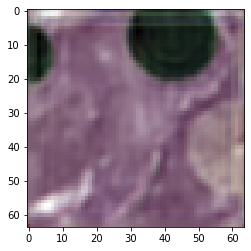

In [55]:
imshow(ae1_out, bands=(29,19,12))

ImageView object:
  Display bands       :  (29, 19, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.08552920509442248, 0.3042380324989021]
    G: [0.1795125164690382, 0.3252086078173035]
    B: [0.20663153271848925, 0.33926218708827405]

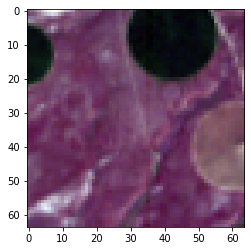

In [56]:
imshow(test_images_1, bands=(29,19,12))

In [36]:
all_final = load_data(r"E:\intermediate_notebooks\hermi2004_final");# List containing names (string) of the datasets in pavC

E:\intermediate_notebooks\hermi2004_final----------
Number of Samples :    28


In [37]:
counter = 0;
for i in range(len(all_final)):
    #print("Loading file number: ", all_final[counter])
    temp_or = np.load(all_final[i]);
    temp = np.expand_dims(temp_or, axis=0);
    temp = ae_combined.predict(temp)
    temp = np.squeeze(temp)
    np.save(pathlib.Path(r"E:\dim_reduc_desktop1_cae\dim_reduc_hermi", '{:03d}'.format(counter)).with_suffix(".npy"), temp)
    counter +=1
print(counter)

28


In [38]:
all_recon = load_data(r"E:\dim_reduc_desktop1_cae\dim_reduc_hermi");# List containing names (string) of the datasets in pavC

E:\dim_reduc_desktop1_cae\dim_reduc_hermi----------
Number of Samples :    28


In [40]:
np.load(all_recon[20]).shape

(64, 64, 242)

In [49]:
recon_im = np.zeros((448, 258, 242))
recon_im.shape

(448, 258, 242)

In [50]:
counter = 0;
for r in range(0, recon_im.shape[0], 64):
    for c in range(0, recon_im.shape[1], 64):
        temp = np.load(all_recon[counter])
        print(temp.shape)
        recon_im[r:r+64, c:c+64, :] = temp 
        counter +=1;
print(counter)

(64, 64, 242)
(64, 64, 242)
(64, 64, 242)
(64, 64, 242)
(64, 64, 242)


ValueError: could not broadcast input array from shape (64,64,242) into shape (64,2,242)

In [44]:
recon_im = recon_im[0:1096, 0:715, :]

ImageView object:
  Display bands       :  (29, 19, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.04581744968891144, 0.8380171656608582]
    G: [-0.05503397434949875, 0.8115893602371216]
    B: [-0.05575374513864517, 0.7780330181121826]

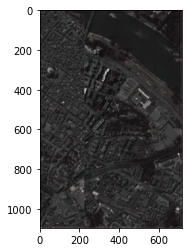

In [45]:
imshow(recon_im, bands=(29,19,12))

In [46]:
final_im = np.zeros((1152, 768, 102))

In [47]:
counter = 0;
for r in range(0, final_im.shape[0], 64):
    for c in range(0, final_im.shape[1], 64):
        final_im[r:r+64, c:c+64, :] = np.load(all_final[counter])
        counter +=1;
print(counter)

216


In [48]:
final_im = final_im[0:1096, 0:715, :]

ImageView object:
  Display bands       :  (29, 19, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1.0]
    G: [0.0, 1.0]
    B: [0.0, 1.0]

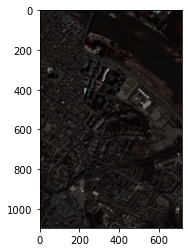

In [49]:
imshow(final_im, bands=(29,19,12))

In [50]:
l1_loss = tf.math.reduce_mean(tf.math.abs(final_im - recon_im))
print(l1_loss)

tf.Tensor(0.015486884513587911, shape=(), dtype=float64)


In [51]:
l2_loss = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(final_im - recon_im)))
print(l2_loss)

tf.Tensor(0.024176862252042394, shape=(), dtype=float64)


In [52]:
np.save(pathlib.Path(r"E:\dim_reduc_desktop1_cae", "pavC_recon_large").with_suffix(".npy"), recon_im)

In [53]:
np.save(pathlib.Path(r"E:\dim_reduc_desktop1_cae", "pavC_original_large").with_suffix(".npy"), final_im)

In [55]:
final_im_re = np.reshape(final_im, (-1, 102))
recon_im_re = np.reshape(recon_im, (-1, 102))
tf.transpose(final_im_re).shape

TensorShape([102, 783640])

In [56]:
normalize_r = tf.math.l2_normalize(tf.transpose(recon_im_re), axis=0)
normalize_t = tf.math.l2_normalize(tf.transpose(final_im_re),axis=0)
spec_angle = tf.math.reduce_mean( tf.math.acos(tf.reduce_mean(tf.multiply(normalize_r, normalize_t),axis=0 ) ) )
spec_angle.numpy()

1.5611292390828206

In [50]:
normalize_r = tf.math.l2_normalize(tf.transpose(recon_im_re),axis=0)
normalize_t = tf.math.l2_normalize(tf.transpose(final_im_re),axis=0)
csa = tf.math.reduce_mean( 1 - tf.math.reduce_mean(tf.math.multiply(normalize_r, normalize_t),axis=0 ) )
csa.numpy()

0.9904003501970063

In [15]:
test_images_1 = np.load(test_images[85])
test_images_2 = np.load(test_images[44])

In [19]:
temp_paired = np.zeros((2, 64, 64, 102))
temp_paired.shape

(2, 64, 64, 102)

In [21]:
temp_paired[0] = test_images_1
temp_paired[1] = test_images_2

In [24]:
out = cae_chkpt.predict(temp_paired)

In [25]:
out.shape

(2, 64, 64, 102)

ImageView object:
  Display bands       :  (29, 19, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.04388653114438057, 0.6561164855957031]
    G: [-0.03856679052114487, 0.6027106046676636]
    B: [-0.031271468847990036, 0.5590817332267761]

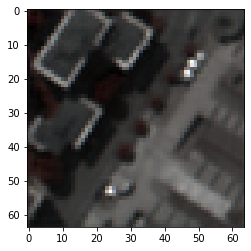

In [26]:
imshow(out[0], bands=(29,19,12))

ImageView object:
  Display bands       :  (29, 19, 12)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 1.0]
    G: [0.0, 1.0]
    B: [0.0, 1.0]

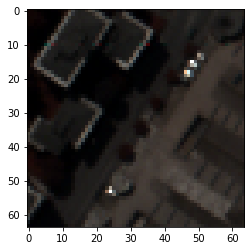

In [27]:
imshow(test_images_1, bands=(29,19,12))